In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import seaborn as sns
import scipy.stats as s
import pyodbc

Poprawne połączenie tabeli sesja z tabelami zawierajacymi informacje o produkcie ("piekna"). Tabela bestia jest kopią tabeli pieknej. Utworznie zmiennej dziecko, połączenie zmiennych związanych z rozmiarem. Pogrupowanie grup kolorów i zapisanie tabeli bestia do csv

In [2]:
server_name = '127.0.0.1, 1433'  # dbserver.mif.pg.gda.pl,1433
db_name = 'silkycoders'  # 'silkycoders'
driver_name = 'ODBC Driver 17 for SQL Server'
uid_string = ''
pwd_string = '' # HASLO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

windows_credentials = False

if windows_credentials:
    trusted_connection = 'yes'
else:
    trusted_connection = 'no'

conn_string_suffix = f'Trusted_Connection={trusted_connection}'
if windows_credentials:
    conn_string = f'DRIVER={{{driver_name}}};' \
        f'SERVER={server_name};' \
        f'DATABASE={db_name};' \
        f'{conn_string_suffix};'
else:
#     uid_string = '<nazwa_uzytkownika>'
#     pwd_string = '<haslo>'
    conn_string = f'DRIVER={{{driver_name}}};' \
        f'SERVER={server_name};' \
        f'DATABASE={db_name};' \
        f'UID={uid_string};' \
        f'PWD={pwd_string};' \
        f'{conn_string_suffix};'

conn = pyodbc.connect(conn_string)

# Sesja użytkowników

In [3]:
sesja = pd.read_sql(''' SELECT *  FROM seg.ClientSessions TABLESAMPLE(100 PERCENT)
''', conn)

In [4]:
#Usuwamy niepotrzebną zmienną ID
sesja.drop(['ID'],axis='columns', inplace=True)

In [5]:
#Sprawdzamy czy w tabeli znajdują się duplikaty
sesja.duplicated().sum()

0

In [6]:
sesja.info()
sesja.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9419902 entries, 0 to 9419901
Data columns (total 16 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   ClientID                      object
 1   ContentID                     object
 2   AvgTimeOnPage                 int64 
 3   ViewsCount                    int64 
 4   WasAddedToCart                bool  
 5   WasBought                     bool  
 6   Size                          object
 7   SizeCheckInStore              object
 8   SizeAvailabilityNotification  object
 9   SizeChosen                    object
 10  RecommendationClickCount      int64 
 11  OpenSizeTab                   bool  
 12  ChangeImage                   int64 
 13  AccordionExpand               int64 
 14  NewUserId                     object
 15  RegisterFlag                  bool  
dtypes: bool(4), int64(5), object(7)
memory usage: 898.4+ MB


ClientID  ContentID  AvgTimeOnPage  ViewsCount  WasAddedToCart  \
0  629835214461368392  0574C-77X          14435           1           False   
1  629835214461368392  1072H-85X          10067           1           False   
2  629835214461368392  1870I-99X          23176           1           False   
3  629835214461368392  2899H-99X          11639           1           False   
4  629835214461368392  4918B-87X          20549           1           False   

   WasBought  Size SizeCheckInStore SizeAvailabilityNotification SizeChosen  \
0      False  None             None                         None       None   
1      False  None             None                         None       None   
2      False  None             None                         None       None   
3      False  None             None                         None       None   
4      False  None             None                         None       None   

   RecommendationClickCount  OpenSizeTab  ChangeImage  AccordionExpand  \
0                         0        False            5                0   
1                         0        False            4                0   
2                         0        False           11                0   
3                         0        False            4                0   
4                         0        False            5                0   

            NewUserId  RegisterFlag  
0  629835214461368392         False  
1  629835214461368392         False  
2  629835214461368392         False  
3  629835214461368392         False  
4  629835214461368392         False

# Jedna tabela

In [7]:
# Wczytujemy tabele charakterystyk
Charakterystyki = pd.read_sql('''SELECT DISTINCT
   sch1.Stylecolor,
   STUFF((SELECT ', ' + sch2.Characteristic
    FROM seg.StclCharacteristic as sch2
    WHERE sch2.Stylecolor= sch1.Stylecolor
    FOR XML PATH('')), 1, 1, '') [Characteristic]
FROM seg.StclCharacteristic as sch1
GROUP BY sch1.Stylecolor, sch1.Characteristic
ORDER BY 1
''', conn)

In [8]:
piekna=pd.merge(sesja, Charakterystyki, left_on='ContentID', right_on='Stylecolor', how='left')

In [9]:
piekna.drop(['Stylecolor'],axis='columns', inplace=True)

In [10]:
status = pd.read_sql(''' SELECT * FROM seg.StclSaleStatus ''', conn)
status

Stylecolor SaleStatus
0      H3596-59X    Nonsale
1      H4940-93X    Nonsale
2      H5135-MLC    Nonsale
3      5949B-00X       Sale
4      H4041-MLC    Nonsale
...          ...        ...
32710  H4260-MLC    Nonsale
32711  H4381-MLC    Nonsale
32712  H4750-MLC    Nonsale
32713  H4498-77X    Nonsale
32714  H4208-MLC    Nonsale

[32715 rows x 2 columns]

In [11]:
stat=status.groupby(['Stylecolor']).count()
pd.DataFrame(stat.loc[stat['SaleStatus'] > 1])

SaleStatus
Stylecolor            
0381I-01X            2
0381I-MLC            2
3196G-45X            2
3567I-MLC            2
5034B-05X            2
5034B-MLC            2
5411G-MLC            2
5922B-01X            2
5922B-04X            2
5922B-05X            2
5922B-99X            2
5949B-00X            2
6229G-30X            2
6307G-99X            2
6365G-59X            2
6650E-81X            2
6767G-01X            2
YS940-65M            2
ZJ276-01X            2
ZN342-66X            2
ZN348-60X            2
ZN409-SLV            2
ZN415-24X            2

In [12]:
status=status.sort_values(by=['SaleStatus'])

In [13]:
pd.DataFrame(status.loc[status['Stylecolor'] == '6650E-81X'])

Stylecolor SaleStatus
27383  6650E-81X    Nonsale
12472  6650E-81X       Sale

In [14]:
status=status.drop_duplicates(subset=status.loc[:, status.columns != 'SaleStatus'].columns)

In [15]:
pd.DataFrame(status.loc[status['Stylecolor'] == '6650E-81X'])

Stylecolor SaleStatus
27383  6650E-81X    Nonsale

In [16]:
piekna=pd.merge(piekna,status,left_on='ContentID', right_on='Stylecolor', how='left')

In [17]:
piekna.drop(['Stylecolor'],axis='columns', inplace=True)

In [18]:
cena = pd.read_sql(''' SELECT * FROM seg.StclPriceCategory ''', conn)
cena

Stylecolor PriceCategory
0      5949B-00X           LIP
1      ZN409-SLV           LIP
2      ZN348-60X           LIP
3      ZH750-00X           LIP
4      YM742-50X           HIP
...          ...           ...
31159  3655H-80X           MIP
31160  6682I-MLC           HIP
31161  2018E-99X           MIP
31162  5586I-00X           LIP
31163  0469D-12X           MIP

[31164 rows x 2 columns]

In [19]:
cen=cena.groupby(['Stylecolor']).count()
pd.DataFrame(cen.loc[cen['PriceCategory'] > 1])

PriceCategory
Stylecolor               
0381I-01X               2
0381I-MLC               2
3196G-45X               2
3567I-MLC               2
5034B-05X               2
5034B-MLC               2
5411G-MLC               2
5922B-01X               2
5922B-04X               2
5922B-05X               2
5922B-99X               2
5949B-00X               2
6229G-30X               2
6307G-99X               2
6365G-59X               2
6650E-81X               2
6767G-01X               2
YS940-65M               2
ZJ276-01X               2
ZN342-66X               2
ZN348-60X               2
ZN409-SLV               2
ZN415-24X               2

In [20]:
pd.DataFrame(cena.loc[cena['Stylecolor'] == '3196G-45X'])

Stylecolor PriceCategory
17818  3196G-45X           LIP
23219  3196G-45X           HIP

In [21]:
cena=cena.drop_duplicates(subset=cena.loc[:, cena.columns != 'PriceCategory'].columns)

In [22]:
piekna = pd.merge(piekna,cena,left_on='ContentID', right_on='Stylecolor', how='left')

In [23]:
piekna.drop(['Stylecolor'],axis='columns', inplace=True)

In [24]:
item = pd.read_sql(''' SELECT DISTINCT
   it1.Stylecolor,
   STUFF((SELECT ', ' + it2.Size
    FROM dw.Item as it2
    WHERE it2.StyleColor= it1.StyleColor
    FOR XML PATH('')), 1, 1, '') [AvSizes],
it1.FashionLevel,
it1.ItemSeason,
it1.SubclassID
FROM dw.Item as it1
GROUP BY it1.Stylecolor, it1.Size, it1.FashionLevel, it1.ItemSeason, it1.SubclassID
ORDER BY 1 ''', conn)

In [25]:
delim = ","
item['AvSizes']  = item['AvSizes'].apply(lambda x: delim.join(sorted(x.split(','))))

item

Stylecolor                                     AvSizes  \
0       0000B-GLD                                         ONE   
1       0000D-30X   104, 110, 116, 122, 128, 134, 140, 92, 98   
2       0000F-11X                 104, 110, 116, 122, 128, 98   
3       0000I-91X                      34, 36, 38, 40, 42, 44   
4       0001B-GLD                                         ONE   
...           ...                                         ...   
181149  ZZ996-80X                        L, M, S, XL, XS, XXS   
181150  ZZ996-81X                        L, M, S, XL, XS, XXS   
181151  ZZ996-99X                        L, M, S, XL, XS, XXS   
181152  ZZ998-80X                                         ONE   
181153  ZZ999-99X                                         ONE   

              FashionLevel ItemSeason  SubclassID  
0       Commercial Fashion    SS 2021         309  
1       Commercial Fashion    AW 2021         762  
2       Commercial Fashion    AW 2021         754  
3                    Basic    AW 2021         636  
4       Commercial Fashion    SS 2021         309  
...                    ...        ...         ...  
181149         Seasonal BS    SS 2021         993  
181150         Seasonal BS    SS 2021         993  
181151         Seasonal BS    SS 2021         993  
181152                 N/A    AW 2020         945  
181153                 N/A    SS 2021         945  

[181154 rows x 5 columns]

In [26]:
piekna = pd.merge(piekna,item,left_on='ContentID', right_on='Stylecolor', how='left')

In [27]:
piekna.drop(['Stylecolor'],axis='columns', inplace=True)

In [28]:
subclass = pd.read_sql(''' SELECT * FROM dw.Subclass ''', conn)
subclass

SubclassID       SubclassName  ClassID
0            15           B_shirts       11
1            66          W_jackets       17
2           113            M_belts       38
3           115             M_hats       38
4           132           L_briefs       41
..          ...                ...      ...
459        1013             towels      213
460        1038        nborn_socks      297
461        1045     dresses_jersey      299
462        1056         bed_covers      213
463        1063  K_winter_trousers      225

[464 rows x 3 columns]

In [29]:
piekna = pd.merge(piekna, subclass, left_on='SubclassID', right_on='SubclassID', how='left')

In [30]:
Class = pd.read_sql(''' SELECT * FROM dw.Class ''', conn)
Class

ClassID     ClassName  DepartmentID
0         10      t-shirts             2
1         11        shirts             2
2         12      knitwear             2
3         14  jogging_tops             2
4         15       dresses             2
..       ...           ...           ...
169      297       newborn            16
170      298        shorts            11
171      299       dresses            11
172      300       jackets            11
173      301      trousers            11

[174 rows x 3 columns]

In [31]:
piekna=pd.merge(piekna, Class, left_on='ClassID', right_on='ClassID', how='left')

In [32]:
Department = pd.read_sql(''' SELECT * FROM dw.Department ''', conn)
Department

DepartmentID        DepartmentName  BrandID
0              2           ladies' RES        1
1              3             men's RES        1
2              5       accessories RES        1
3              6       under/socks RES        1
4              9            girls' RES        1
5             10             boys' RES        1
6             11         ladies' CROPP        2
7             12           men's CROPP        2
8             14     accessories CROPP        2
9             16   kid's acc&under RES        1
10            17    ladies' garment SI        3
11            18    ladies' acc SINSAY        3
12            19         ladies' HOUSE        4
13            20           men's HOUSE        4
14            21     accessories HOUSE        4
15            22        ladies' MOHITO        5
16            23    accessories MOHITO        5
17            25           ladies' TAL        8
18            26             men's TAL        8
19            28    advert. mat. CROPP        2
20            39      advert. mat. MOH        5
21            45  kid's garment SINSAY        3
22            46  men's garment SINSAY        3
23            47           home SINSAY        3
24            51  kid's accessories SI        3
25            52      men's acc SINSAY        3

In [33]:
piekna=pd.merge(piekna, Department, left_on='DepartmentID', right_on='DepartmentID', how='left')

In [34]:
Brand = pd.read_sql(''' SELECT * FROM dw.Brand ''', conn)

In [35]:
piekna = pd.merge(piekna, Brand, left_on='BrandID', right_on='BrandID', how='left')

In [36]:
piekna['ColorGroup']=piekna['ContentID'].str[6:8]

In [158]:
client=piekna[['ClientID','NewUserId']]
client=client.drop_duplicates()
newuser=client.groupby(['ClientID']).count()
suma=pd.DataFrame(newuser.loc[newuser['NewUserId'] > 1])
suma['ClientID'] = suma.index
piekna=piekna[~piekna['ClientID'].isin(suma.index)]

In [163]:
piekna.info

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
0        629835214461368392  0574C-77X          14435           1   
1        629835214461368392  1072H-85X          10067           1   
2        629835214461368392  1870I-99X          23176           1   
3        629835214461368392  2899H-99X          11639           1   
4        629835214461368392  4918B-87X          20549           1   
...                     ...        ...            ...         ...   
9419897   99506894811688260  4966C-65X          18751           1   
9419898   99506894811688260  5577B-59X           4823           2   
9419899   99506894811688260  5577B-79X          14273           3   
9419900   99506894811688260  5577B-87X           6954           2   
9419901   99506894811688260  5622B-40X          69377           2   

         WasAddedToCart  WasBought  Size SizeCheckInStore  \
0                 False      False  None             None   
1                 False      False  None             None   
2                 False      False  None             None   
3                 False      False  None             None   
4                 False      False  None             None   
...                 ...        ...   ...              ...   
9419897           False      False  None             None   
9419898           False      False  None             None   
9419899            True      False    40             None   
9419900           False      False  None             None   
9419901           False      False  None             None   

        SizeAvailabilityNotification SizeChosen  ...  SubclassID  \
0                               None       None  ...        17.0   
1                               None       None  ...       637.0   
2                               None       None  ...       628.0   
3                               None       None  ...       108.0   
4                               None       None  ...        53.0   
...                              ...        ...  ...         ...   
9419897                         None         36  ...        15.0   
9419898                         None       None  ...        53.0   
9419899                         None         40  ...        53.0   
9419900                         None       None  ...        53.0   
9419901                         None       None  ...        36.0   

            SubclassName  ClassID            ClassName DepartmentID  \
0               W_shirts     11.0               shirts          2.0   
1        W_outer_jackets    184.0              outwear          2.0   
2            JER_dresses     15.0              dresses          2.0   
3                L_shoes     37.0  ladies'_accessories          5.0   
4             W_trousers     16.0             trousers          2.0   
...                  ...      ...                  ...          ...   
9419897         B_shirts     11.0               shirts          2.0   
9419898       W_trousers     16.0             trousers          2.0   
9419899       W_trousers     16.0             trousers          2.0   
9419900       W_trousers     16.0             trousers          2.0   
9419901        W_dresses     15.0              dresses          2.0   

          DepartmentName BrandID BrandName Active ColorGroup  
0            ladies' RES     1.0  RESERVED   True         77  
1            ladies' RES     1.0  RESERVED   True         85  
2            ladies' RES     1.0  RESERVED   True         99  
3        accessories RES     1.0  RESERVED   True         99  
4            ladies' RES     1.0  RESERVED   True         87  
...                  ...     ...       ...    ...        ...  
9419897      ladies' RES     1.0  RESERVED   True         65  
9419898      ladies' RES     1.0  RESERVED   True         59  
9419899      ladies' RES     1.0  RESERVED   True         79  
9419900      ladies' RES     1.0  RESERVED   True         87  
9419901      ladies' RES     1.0  RESERVED   True         40  

[9367651 rows x 32 columns]

In [166]:
bestia=piekna.copy()

In [167]:
bestia.drop(['Active','BrandName','BrandID','DepartmentName',"ClassName",'SubclassName'],axis='columns', inplace=True)

# Tworzenie zmiennej rozmiar i infodziecko

In [168]:
bestia

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
0        629835214461368392  0574C-77X          14435           1   
1        629835214461368392  1072H-85X          10067           1   
2        629835214461368392  1870I-99X          23176           1   
3        629835214461368392  2899H-99X          11639           1   
4        629835214461368392  4918B-87X          20549           1   
...                     ...        ...            ...         ...   
9419897   99506894811688260  4966C-65X          18751           1   
9419898   99506894811688260  5577B-59X           4823           2   
9419899   99506894811688260  5577B-79X          14273           3   
9419900   99506894811688260  5577B-87X           6954           2   
9419901   99506894811688260  5622B-40X          69377           2   

         WasAddedToCart  WasBought  Size SizeCheckInStore  \
0                 False      False  None             None   
1                 False      False  None             None   
2                 False      False  None             None   
3                 False      False  None             None   
4                 False      False  None             None   
...                 ...        ...   ...              ...   
9419897           False      False  None             None   
9419898           False      False  None             None   
9419899            True      False    40             None   
9419900           False      False  None             None   
9419901           False      False  None             None   

        SizeAvailabilityNotification SizeChosen  ...  \
0                               None       None  ...   
1                               None       None  ...   
2                               None       None  ...   
3                               None       None  ...   
4                               None       None  ...   
...                              ...        ...  ...   
9419897                         None         36  ...   
9419898                         None       None  ...   
9419899                         None         40  ...   
9419900                         None       None  ...   
9419901                         None       None  ...   

                                Characteristic  SaleStatus  PriceCategory  \
0                                  długi rękaw        Sale            MIP   
1                                      płaszcz     Nonsale            HIP   
2                            midi, długi rękaw     Nonsale            MIP   
3                    mokasyny, skóra naturalna     Nonsale            MIP   
4         proste, luźne, high-waisted, dresowe     Nonsale            MIP   
...                                        ...         ...            ...   
9419897                    długi rękaw, gładka        Sale            HIP   
9419898                       chino, z paskiem     Nonsale            MIP   
9419899                       chino, z paskiem     Nonsale            MIP   
9419900                       chino, z paskiem     Nonsale            MIP   
9419901                           krótki rękaw        Sale            HIP   

                             AvSizes FashionLevel  ItemSeason SubclassID  \
0                 34, 36, 38, 40, 42    Core Wall     SS 2021       17.0   
1                        L, M, S, XL         Core     AW 2021      637.0   
2                        L, M, S, XS         Core     AW 2021      628.0   
3             36, 37, 38, 39, 40, 41         Base     AW 2021      108.0   
4             34, 36, 38, 40, 42, 44   Bestseller     AW 2021       53.0   
...                              ...          ...         ...        ...   
9419897   34, 36, 38, 40, 42, 44, 46         Core     SS 2021       15.0   
9419898   34, 36, 38, 40, 42, 44, 46   Bestseller     AW 2021       53.0   
9419899   34, 36, 38, 40, 42, 44, 46   Bestseller     AW 2021       53.0   
9419900   34, 36, 38, 40, 42, 44, 46   Bestseller     AW 2021       53.0   
9419901       34, 36, 3

In [169]:
bestia['DepartmentID'].unique()

array([ 2.,  5.,  9.,  3., 10.,  6., 16., nan])

In [170]:
acc=[5,6]
bestia['DepartmentName'] = ['ladies' if x==2 else ('men' if x==3 else ('accessories' if x in acc else 'kids')) for x in bestia.loc[:,'DepartmentID']]

In [171]:
bestia

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
0        629835214461368392  0574C-77X          14435           1   
1        629835214461368392  1072H-85X          10067           1   
2        629835214461368392  1870I-99X          23176           1   
3        629835214461368392  2899H-99X          11639           1   
4        629835214461368392  4918B-87X          20549           1   
...                     ...        ...            ...         ...   
9419897   99506894811688260  4966C-65X          18751           1   
9419898   99506894811688260  5577B-59X           4823           2   
9419899   99506894811688260  5577B-79X          14273           3   
9419900   99506894811688260  5577B-87X           6954           2   
9419901   99506894811688260  5622B-40X          69377           2   

         WasAddedToCart  WasBought  Size SizeCheckInStore  \
0                 False      False  None             None   
1                 False      False  None             None   
2                 False      False  None             None   
3                 False      False  None             None   
4                 False      False  None             None   
...                 ...        ...   ...              ...   
9419897           False      False  None             None   
9419898           False      False  None             None   
9419899            True      False    40             None   
9419900           False      False  None             None   
9419901           False      False  None             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
0                               None       None  ...        Sale   
1                               None       None  ...     Nonsale   
2                               None       None  ...     Nonsale   
3                               None       None  ...     Nonsale   
4                               None       None  ...     Nonsale   
...                              ...        ...  ...         ...   
9419897                         None         36  ...        Sale   
9419898                         None       None  ...     Nonsale   
9419899                         None         40  ...     Nonsale   
9419900                         None       None  ...     Nonsale   
9419901                         None       None  ...        Sale   

         PriceCategory                      AvSizes  FashionLevel ItemSeason  \
0                  MIP           34, 36, 38, 40, 42     Core Wall    SS 2021   
1                  HIP                  L, M, S, XL          Core    AW 2021   
2                  MIP                  L, M, S, XS          Core    AW 2021   
3                  MIP       36, 37, 38, 39, 40, 41          Base    AW 2021   
4                  MIP       34, 36, 38, 40, 42, 44    Bestseller    AW 2021   
...                ...                          ...           ...        ...   
9419897            HIP   34, 36, 38, 40, 42, 44, 46          Core    SS 2021   
9419898            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419899            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419900            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419901            HIP       34, 36, 38, 40, 42, 44          Core    SS 2021   

         SubclassID ClassID DepartmentID ColorGroup DepartmentName  
0              17.0    11.0          2.0         77         ladies  
1             637.0   184.0          2.0         85         ladies  
2             628.0    15.0          2.0         99         ladies  
3             108.0    37.0          5.0         99    accessories  
4              53.0    16.0          2.0         87         ladies  
...             ...     ...          ...        ...            ...  
9419897        15.0    11.0          2.0         65         ladies  
9419898        53.0    16.0          2.0         59         ladies  
9419899        53.0    16.0          2.0         79       

In [172]:
df=bestia.copy()

In [173]:
df['Size'] = df['Size'].str.replace(" ","_")
df['SizeCheckInStore'] = df['SizeCheckInStore'].str.replace(" ","_")
df['SizeAvailabilityNotification'] = df['SizeAvailabilityNotification'].str.replace(" ","_")
df['SizeChosen'] = df['SizeChosen'].str.replace(" ","_")

# Ladies

In [174]:
ladies_s=['32','34','36','XS/S','S','XS','XXS','X/S']
ladies_m=['38','40','M','S/M','M/L','ONE_SIZE','ONE','standard']
ladies_l=['42','44','46','L','L/XL','XL','XXL','L/X']

In [175]:
ladies=pd.DataFrame(df.loc[df['DepartmentName'] == 'ladies'])

In [176]:
ladies

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
0        629835214461368392  0574C-77X          14435           1   
1        629835214461368392  1072H-85X          10067           1   
2        629835214461368392  1870I-99X          23176           1   
4        629835214461368392  4918B-87X          20549           1   
5        629835214461368392  5696B-09M          15107           1   
...                     ...        ...            ...         ...   
9419897   99506894811688260  4966C-65X          18751           1   
9419898   99506894811688260  5577B-59X           4823           2   
9419899   99506894811688260  5577B-79X          14273           3   
9419900   99506894811688260  5577B-87X           6954           2   
9419901   99506894811688260  5622B-40X          69377           2   

         WasAddedToCart  WasBought  Size SizeCheckInStore  \
0                 False      False  None             None   
1                 False      False  None             None   
2                 False      False  None             None   
4                 False      False  None             None   
5                 False      False  None             None   
...                 ...        ...   ...              ...   
9419897           False      False  None             None   
9419898           False      False  None             None   
9419899            True      False    40             None   
9419900           False      False  None             None   
9419901           False      False  None             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
0                               None       None  ...        Sale   
1                               None       None  ...     Nonsale   
2                               None       None  ...     Nonsale   
4                               None       None  ...     Nonsale   
5                               None       None  ...        Sale   
...                              ...        ...  ...         ...   
9419897                         None         36  ...        Sale   
9419898                         None       None  ...     Nonsale   
9419899                         None         40  ...     Nonsale   
9419900                         None       None  ...     Nonsale   
9419901                         None       None  ...        Sale   

         PriceCategory                      AvSizes  FashionLevel ItemSeason  \
0                  MIP           34, 36, 38, 40, 42     Core Wall    SS 2021   
1                  HIP                  L, M, S, XL          Core    AW 2021   
2                  MIP                  L, M, S, XS          Core    AW 2021   
4                  MIP       34, 36, 38, 40, 42, 44    Bestseller    AW 2021   
5                  HIP   34, 36, 38, 40, 42, 44, 46         Basic    SS 2021   
...                ...                          ...           ...        ...   
9419897            HIP   34, 36, 38, 40, 42, 44, 46          Core    SS 2021   
9419898            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419899            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419900            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419901            HIP       34, 36, 38, 40, 42, 44          Core    SS 2021   

         SubclassID ClassID DepartmentID ColorGroup DepartmentName  
0              17.0    11.0          2.0         77         ladies  
1             637.0   184.0          2.0         85         ladies  
2             628.0    15.0          2.0         99         ladies  
4              53.0    16.0          2.0         87         ladies  
5             636.0   184.0          2.0         09         ladies  
...             ...     ...          ...        ...            ...  
9419897        15.0    11.0          2.0         65         ladies  
9419898        53.0    16.0          2.0         59         ladies  
9419899        53.0    16.0          2.0         79       

In [177]:
ladies['Size'] = ['S' if x in ladies_s else ('M' if x in ladies_m else ('L' if x in ladies_l else None)) for x in ladies.loc[:,'Size']]
ladies['SizeCheckInStore'] = ['S' if x in ladies_s else ('M' if x in ladies_m else ('L' if x in ladies_l else None)) for x in ladies.loc[:,'SizeCheckInStore']]
ladies['SizeAvailabilityNotification'] = ['S' if x in ladies_s else ('M' if x in ladies_m else ('L' if x in ladies_l else None)) for x in ladies.loc[:,'SizeAvailabilityNotification']]
ladies['SizeChosen'] = ['S' if x in ladies_s else ('M' if x in ladies_m else ('L' if x in ladies_l else None)) for x in ladies.loc[:,'SizeChosen']]

In [178]:
ladies['Size'].unique()

array([None, 'S', 'M', 'L'], dtype=object)

In [179]:
ladies['SizeCheckInStore'].unique()

array([None, 'M', 'L', 'S'], dtype=object)

In [180]:
ladies['SizeAvailabilityNotification'].unique()

array([None, 'M', 'S', 'L'], dtype=object)

In [181]:
ladies['SizeChosen'].unique()

array([None, 'S', 'L', 'M'], dtype=object)

# Men

In [182]:
men=pd.DataFrame(df.loc[df['DepartmentName'] == 'men'])

In [183]:
men

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
30       6298377070840414774  4408C-99X          16371           2   
65       6298398528497624384  6274H-09M            792           1   
66       6298398528497624384  6274H-59M          13867           1   
165      6298319428085806304  3136C-90M          14545           1   
166      6298319428085806304  XP139-57M          37601           1   
...                      ...        ...            ...         ...   
9419729   995001198031675807  4783C-00X           8394           1   
9419730   995001198031675807  4784C-59M           9559           1   
9419731   995001198031675807  XJ958-59M          11970           1   
9419732   995001198031675807  XL110-59M          28602           1   
9419733   995001198031675807  YU907-00X          40274           1   

         WasAddedToCart  WasBought  Size SizeCheckInStore  \
30                False      False  None             None   
65                False      False  None             None   
66                False      False  None             None   
165               False      False  None             None   
166               False      False  None             None   
...                 ...        ...   ...              ...   
9419729           False      False  None             None   
9419730           False      False  None             None   
9419731           False      False  None             None   
9419732           False      False  None             None   
9419733           False      False  None             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
30                                 S       None  ...        Sale   
65                              None       None  ...     Nonsale   
66                              None       None  ...     Nonsale   
165                             None       None  ...        Sale   
166                             None         48  ...        Sale   
...                              ...        ...  ...         ...   
9419729                         None       None  ...        Sale   
9419730                         None       None  ...        Sale   
9419731                         None       None  ...        Sale   
9419732                         None       None  ...        Sale   
9419733                            M       None  ...        Sale   

         PriceCategory                      AvSizes  FashionLevel ItemSeason  \
30                 HIP             L, M, S, XL, XXL          Base    SS 2021   
65                 LIP             L, M, S, XL, XXL          Base    AW 2021   
66                 LIP             L, M, S, XL, XXL          Base    AW 2021   
165                MIP   29, 30, 31, 32, 33, 34, 36          Core    SS 2021   
166                NaN           48, 50, 52, 54, 56          Base    AW 2020   
...                ...                          ...           ...        ...   
9419729            MIP                  L, M, S, XL          Base    SS 2021   
9419730            HIP             L, M, S, XL, XXL          Base    SS 2021   
9419731            MIP             L, M, S, XL, XXL          Base    SS 2021   
9419732            MIP             L, M, S, XL, XXL          Core    SS 2021   
9419733            MIP                  L, M, S, XL          Core    SS 2021   

         SubclassID ClassID DepartmentID ColorGroup DepartmentName  
30             82.0    25.0          3.0         99            men  
65            849.0    20.0          3.0         09            men  
66            849.0    20.0          3.0         59            men  
165           672.0    23.0          3.0         90            men  
166          1014.0    23.0          3.0         57            men  
...             ...     ...          ...        ...            ...  
9419729       734.0   198.0          3.0         00            men  
9419730       734.0   198.0          3.0         59            men  
9419731       734.0   198.0          3.0       

In [184]:
men_s=['28','29','30','31','46','48','S/M','S','XS','XS/S','XXS','30/32','31/32','29/32','28/32','302','312','292','282']
men_m=['32','33','34','50','52','M/L','ONE_SIZE','ONE','standard','M','34/32','34/34','32/32','33/32','32/34','33/34','342','324','344','332','334','322']
men_l=['36','38','54','56','L/XL','XL/XXL','XXL','XL','L','36/34','38/34','L/X','384','364']

In [185]:
men['Size'] = ['S' if x in men_s else ('M' if x in men_m else ('L' if x in men_l else None)) for x in men.loc[:,'Size']]
men['SizeCheckInStore'] = ['S' if x in men_s else ('M' if x in men_m else ('L' if x in men_l else None)) for x in men.loc[:,'SizeCheckInStore']]
men['SizeAvailabilityNotification'] = ['S' if x in men_s else ('M' if x in men_m else ('L' if x in men_l else None)) for x in men.loc[:,'SizeAvailabilityNotification']]
men['SizeChosen'] = ['S' if x in men_s else ('M' if x in men_m else ('L' if x in men_l else None)) for x in men.loc[:,'SizeChosen']]

In [186]:
men['Size'].unique()

array([None, 'L', 'S', 'M'], dtype=object)

In [187]:
men['SizeCheckInStore'].unique()

array([None, 'L', 'M', 'S'], dtype=object)

In [188]:
men['SizeAvailabilityNotification'].unique()

array(['S', None, 'L', 'M'], dtype=object)

In [189]:
men['SizeChosen'].unique()

array([None, 'S', 'L', 'M'], dtype=object)

In [190]:
pd.DataFrame(df.loc[df['Size'] == 'simitems_1'])

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
117903   5704683264748223033  XJ527-59J           5029           1   
140303   6522313367119676226  3545I-99X          28747           1   
201979   6304066648380031865  8931H-08X           1988           2   
201982   6304066648380031865  8931H-50X           1993           3   
201983   6304066648380031865  8931H-99X           2726           1   
...                      ...        ...            ...         ...   
8595352  8577489169961509446  1060H-80X          36332           2   
8595353  8577489169961509446  1060H-87X           9910           1   
8957750  8900253698821970333  YT014-83J          10583           1   
9054562  8972385338096078146  XV385-03X           6596           2   
9391789   969134401028147722  8371B-03X          17927           1   

         WasAddedToCart  WasBought        Size SizeCheckInStore  \
117903             True      False  simitems_1             None   
140303             True      False  simitems_1             None   
201979             True      False  simitems_1             None   
201982             True      False  simitems_1             None   
201983             True      False  simitems_1             None   
...                 ...        ...         ...              ...   
8595352            True      False  simitems_1               36   
8595353            True      False  simitems_1             None   
8957750            True      False  simitems_1             None   
9054562            True      False  simitems_1             None   
9391789            True      False  simitems_1             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
117903                          None       None  ...        Sale   
140303                            34       None  ...        Sale   
201979                          None       None  ...     Nonsale   
201982                          None       None  ...     Nonsale   
201983                          None       None  ...     Nonsale   
...                              ...        ...  ...         ...   
8595352                           36       None  ...     Nonsale   
8595353                         None       None  ...     Nonsale   
8957750                         None       None  ...        Sale   
9054562                         None       None  ...        Sale   
9391789                         None       None  ...        Sale   

         PriceCategory                               AvSizes  FashionLevel  \
117903             LIP            29, 30, 32, 33, 34, 36, 38          Base   
140303             MIP                    34, 36, 38, 40, 42   Directional   
201979             MIP                               L, M, S         Basic   
201982             MIP                               L, M, S         Basic   
201983             MIP                               L, M, S         Basic   
...                ...                                   ...           ...   
8595352            MIP            34, 36, 38, 40, 42, 44, 46    Core Floor   
8595353            MIP            34, 36, 38, 40, 42, 44, 46    Core Floor   
8957750            LIP                34, 36, 38, 40, 42, 44          Base   
9054562            HIP   34, 36, 38, 40, 42, L, M, S, XL, XS          Core   
9391789            MIP                    34, 36, 38, 40, 42    Bestseller   

        ItemSeason  SubclassID ClassID DepartmentID ColorGroup DepartmentName  
117903     SS 2021       724.0   194.0          3.0         59            men  
140303     SS 2021        36.0    15.0          2.0         99         ladies  
201979     AW 2021      1016.0    12.0          2.0         08         ladies  
201982     AW 2021      1016.0    12.0          2.0         50         ladies  
201983     AW 2021      1016.0    12.0          2.0         99         ladies  
...            ...         ...     ...          ...        ...            ...  
8595352    AW 2021       637.0   184.0          2.0         

In [191]:
pd.DataFrame(df.loc[df['Size'] == 'collab_1'])

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
73632    5296965098857979678  1172C-08X           3490           1   
73633    5296965098857979678  1172C-70X           3402           2   
73634    5296965098857979678  1172C-99X            953           1   
110212   5297189549552607885  7577H-39X           5838           4   
201980   6304066648380031865  8931H-08X           1988           2   
...                      ...        ...            ...         ...   
7662288  7752716227777714248  YW397-99X           4820           1   
8071947  8119238824034617931  YR980-59X           3244           2   
8611699  8593042560814120413  0533C-01X           3374           1   
8734533  8699587853179735775  0128I-99X         128660           1   
9287127   918598024825071559  0922I-80M          12929           1   

         WasAddedToCart  WasBought      Size SizeCheckInStore  \
73632              True      False  collab_1             None   
73633              True      False  collab_1             None   
73634              True      False  collab_1             None   
110212             True      False  collab_1             None   
201980             True      False  collab_1             None   
...                 ...        ...       ...              ...   
7662288            True      False  collab_1             None   
8071947            True      False  collab_1             None   
8611699            True      False  collab_1             None   
8734533            True      False  collab_1             None   
9287127            True      False  collab_1             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
73632                           None       None  ...        Sale   
73633                           None       None  ...        Sale   
73634                           None       None  ...        Sale   
110212                          None       None  ...     Nonsale   
201980                          None       None  ...     Nonsale   
...                              ...        ...  ...         ...   
7662288                         None       None  ...     Nonsale   
8071947                         None       None  ...        Sale   
8611699                         None       None  ...        Sale   
8734533                         None       None  ...     Nonsale   
9287127                         None         XS  ...     Nonsale   

         PriceCategory                  AvSizes  FashionLevel ItemSeason  \
73632              LIP              L, M, S, XS         Basic    SS 2021   
73633              LIP              L, M, S, XS         Basic    SS 2021   
73634              LIP              L, M, S, XS         Basic    SS 2021   
110212             MIP                  L, M, S    Core Floor    AW 2021   
201980             MIP                  L, M, S         Basic    AW 2021   
...                ...                      ...           ...        ...   
7662288            LIP     L, M, S, XL, XS, XXL          Base    AW 2021   
8071947            LIP   34, 36, 38, 40, 42, 44         Basic    SS 2021   
8611699            HIP          L, M, S, XL, XS    Bestseller    SS 2021   
8734533            MIP          L, M, S, XL, XS     Core Wall    AW 2021   
9287127            LIP          L, M, S, XL, XS    Core Floor    AW 2021   

         SubclassID ClassID DepartmentID ColorGroup DepartmentName  
73632         628.0    15.0          2.0         08         ladies  
73633         628.0    15.0          2.0         70         ladies  
73634         628.0    15.0          2.0         99         ladies  
110212       1016.0    12.0          2.0         39         ladies  
201980       1016.0    12.0          2.0         08         ladies  
...             ...     ...          ...        ...            ...  
7662288       663.0    19.0          3.0         99            men  
8071947        52.0    16.0          2.0         59         ladies  
8611699        21.0    14.0          2.0       

# Kids

In [192]:
kids=pd.DataFrame(df.loc[df['DepartmentName'] == 'kids'])

In [193]:
kids

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
18       6298374081547046372  ZD819-05J          31619           1   
73       6298413303186218362  3900G-55J           5389           1   
90       6298430891010527927  3037D-00X          21225           1   
91       6298430891010527927  3184G-34X         123251           5   
105       629825254434544006  4791G-80X          16577           2   
...                      ...        ...            ...         ...   
9419790   995029136816472656  ZV697-SLV          90343           5   
9419822   995041639425730227  5093D-79X          17704           1   
9419826   995041639425730227  5477E-79X          18722           1   
9419855    99506800360300550  5540G-09M              1           1   
9419856    99506800360300550  8151D-59X          64260           1   

         WasAddedToCart  WasBought      Size SizeCheckInStore  \
18                False      False      None             None   
73                False      False      None             None   
90                False      False      None             None   
91                False      False      None              164   
105               False      False      None             None   
...                 ...        ...       ...              ...   
9419790            True      False  ONE_SIZE         ONE_SIZE   
9419822            True      False        30             None   
9419826            True      False        29             None   
9419855           False      False      None             None   
9419856           False      False      None             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
18                              None       None  ...        Sale   
73                              None       None  ...     Nonsale   
90                              None       None  ...        Sale   
91                              None        164  ...     Nonsale   
105                             None       None  ...     Nonsale   
...                              ...        ...  ...         ...   
9419790                         None       None  ...     Nonsale   
9419822                         None         30  ...        Sale   
9419826                         None         29  ...        Sale   
9419855                         None       None  ...     Nonsale   
9419856                         None       None  ...     Nonsale   

         PriceCategory                                            AvSizes  \
18                 HIP                       134, 140, 146, 152, 158, 164   
73                 HIP                           104, 110, 80, 86, 92, 98   
90                 MIP     27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38   
91                 MIP        116, 122, 128, 134, 140, 146, 152, 158, 164   
105                LIP                              221, 223, 225, 26, 27   
...                ...                                                ...   
9419790            MIP                                                ONE   
9419822            LIP   27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...   
9419826            LIP                             27, 28, 29, 30, 31, 32   
9419855            HIP                            K25, K28, K31, K34, K37   
9419856            HIP   110, 116, 122, 128, 134, 140, 146, 152, 158, ...   

         FashionLevel ItemSeason  SubclassID ClassID DepartmentID ColorGroup  \
18         Bestseller    SS 2021       879.0   242.0          9.0         05   
73               Core    AW 2021       860.0   240.0         10.0         55   
90               Core    SS 2021       923.0   262.0         16.0         00   
91              Basic    AW 2021       172.0    53.0          9.0         34   
105             Basic    AW 2021       906.0   253.0         16.0         80   
...               ...        ...         ...     ...          ...        ...   
9419790          Core    AW 2021       911.0   256.0         16.0         SL   
9419822         

In [194]:
kids_all=kids['Size'].unique()

In [195]:
kids_all=np.delete(kids_all, 0)

In [196]:
kids['Size'] = ['K' if x in kids_all else x for x in kids.loc[:,'Size']]
kids['SizeCheckInStore'] = ['K' if x in kids_all else x for x in kids.loc[:,'SizeCheckInStore']]
kids['SizeAvailabilityNotification'] = ['K' if x in kids_all else x for x in kids.loc[:,'SizeAvailabilityNotification']]
kids['SizeChosen'] = ['K' if x in kids_all else x for x in kids.loc[:,'SizeChosen']]

In [197]:
kids['Size'].unique()

array([None, 'K'], dtype=object)

In [198]:
kids['SizeCheckInStore'].unique()

array([None, 'K'], dtype=object)

In [199]:
kids['SizeAvailabilityNotification'].unique()

array([None, 'K'], dtype=object)

In [200]:
kids['SizeChosen'].unique()

array([None, 'K'], dtype=object)

In [201]:
#kids_s=['56','62', '68', '74', '80']
#kids_m=['86', '92', '98', '104', '110','ONE_SIZE','ONE','standard']
#kids_l=['116', '122', '128', '134', '140', '146', '152', '158', '164', '170', 'U12', 'U13', 'U14', 'U15', '158/164', '146/152','134/140','122/128']

# Akcesoria

In [202]:
accessories=pd.DataFrame(df.loc[df['DepartmentName'] == 'accessories'])

In [203]:
accessories

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
3         629835214461368392  2899H-99X          11639           1   
7         629835214461368392  8995D-39X           9988           1   
76       6298421257467477664  1671A-99X          68153           1   
77       6298421257467477664  2058H-99X           7328           3   
78       6298421257467477664  XV850-99X          20225           1   
...                      ...        ...            ...         ...   
9419713   994975737466825006  5870E-39X          44654           1   
9419715   994975737466825006  7131E-50X          23494           1   
9419734   995002976171285510  8850E-01X          26428           1   
9419747   995012897529927804  0528H-99X          50057           1   
9419749   995012897529927804  1643A-99X          29142           1   

         WasAddedToCart  WasBought      Size SizeCheckInStore  \
3                 False      False      None             None   
7                 False      False      None             None   
76                False      False      None             None   
77                 True      False  ONE_SIZE             None   
78                False      False      None             None   
...                 ...        ...       ...              ...   
9419713           False      False      None             None   
9419715           False      False      None             None   
9419734           False      False      None               38   
9419747           False      False      None             None   
9419749           False      False      None             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
3                               None       None  ...     Nonsale   
7                               None       None  ...        Sale   
76                          ONE_SIZE       None  ...        Sale   
77                              None       None  ...     Nonsale   
78                              None       None  ...         NaN   
...                              ...        ...  ...         ...   
9419713                         None       None  ...        Sale   
9419715                         None       None  ...        Sale   
9419734                         None         38  ...        Sale   
9419747                         None       None  ...     Nonsale   
9419749                         None       None  ...     Nonsale   

         PriceCategory                  AvSizes  FashionLevel ItemSeason  \
3                  MIP   36, 37, 38, 39, 40, 41          Base    AW 2021   
7                  MIP   36, 37, 38, 39, 40, 41          Core    SS 2021   
76                 MIP                      ONE          Core    AW 2020   
77                 MIP                      ONE   Directional    AW 2021   
78                 NaN                      ONE         Trend    AW 2019   
...                ...                      ...           ...        ...   
9419713            MIP   36, 37, 38, 39, 40, 41          Base    SS 2021   
9419715            LIP                      ONE          Base    SS 2021   
9419734            HIP       34, 36, 38, 40, 42           N/A    SS 2021   
9419747            MIP                      ONE          Base    AW 2021   
9419749            MIP                      ONE          Core    AW 2021   

         SubclassID ClassID DepartmentID ColorGroup DepartmentName  
3             108.0    37.0          5.0         99    accessories  
7             108.0    37.0          5.0         39    accessories  
76            102.0    37.0          5.0         99    accessories  
77            102.0    37.0          5.0         99    accessories  
78            102.0    37.0          5.0         99    accessories  
...             ...     ...          ...        ...            ...  
9419713       109.0    37.0          5.0         39    accessories  
9419715       106.0    37.0          5.0         50    accessories  
9419734       135.0    41.0          6.0       

In [204]:
accessories_s=['70A','70B','70C','70D','70E','XS','XXS','XS/S','X/S','70B/75A','A','34','36','38', '37','35-38','33', '35', '31', '32', '29',
       '27', '30', '28', '24/25', '22/23', '26', '20/21','28/29','26/27','38/39','35R']
accessories_m=['75A','75B','75C','75D','75E','M','S','L','standard','ONE_SIZE','ONE','S/M','B','M/L','39','40','41','39-42','42','39R']
accessories_l=['80A','80B','80C','80D','80E','XL','XXL','L/XL','L/X','75C/80B','C','43', '44','45','46','47','43-46','43R']

In [205]:
accessories['Size'] = ['S' if x in accessories_s else ('M' if x in accessories_m else ('L' if x in accessories_l else None)) for x in accessories.loc[:,'Size']]
accessories['SizeCheckInStore'] = ['S' if x in accessories_s else ('M' if x in accessories_m else ('L' if x in accessories_l else None)) for x in accessories.loc[:,'SizeCheckInStore']]
accessories['SizeAvailabilityNotification'] = ['S' if x in accessories_s else ('M' if x in accessories_m else ('L' if x in accessories_l else None)) for x in accessories.loc[:,'SizeAvailabilityNotification']]
accessories['SizeChosen'] = ['S' if x in accessories_s else ('M' if x in accessories_m else ('L' if x in accessories_l else None)) for x in accessories.loc[:,'SizeChosen']]

In [206]:
accessories['Size'].unique()

array([None, 'M', 'S', 'L'], dtype=object)

In [207]:
accessories['SizeCheckInStore'].unique()

array([None, 'M', 'L', 'S'], dtype=object)

In [208]:
accessories['SizeAvailabilityNotification'].unique()

array([None, 'M', 'S', 'L'], dtype=object)

In [209]:
accessories['SizeChosen'].unique()

array([None, 'S', 'M', 'L'], dtype=object)

# Połączenie tabeli

In [210]:
result = men.append(ladies.append(kids.append(accessories)))

In [211]:
result

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
30       6298377070840414774  4408C-99X          16371           2   
65       6298398528497624384  6274H-09M            792           1   
66       6298398528497624384  6274H-59M          13867           1   
165      6298319428085806304  3136C-90M          14545           1   
166      6298319428085806304  XP139-57M          37601           1   
...                      ...        ...            ...         ...   
9419713   994975737466825006  5870E-39X          44654           1   
9419715   994975737466825006  7131E-50X          23494           1   
9419734   995002976171285510  8850E-01X          26428           1   
9419747   995012897529927804  0528H-99X          50057           1   
9419749   995012897529927804  1643A-99X          29142           1   

         WasAddedToCart  WasBought  Size SizeCheckInStore  \
30                False      False  None             None   
65                False      False  None             None   
66                False      False  None             None   
165               False      False  None             None   
166               False      False  None             None   
...                 ...        ...   ...              ...   
9419713           False      False  None             None   
9419715           False      False  None             None   
9419734           False      False  None                S   
9419747           False      False  None             None   
9419749           False      False  None             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
30                                 S       None  ...        Sale   
65                              None       None  ...     Nonsale   
66                              None       None  ...     Nonsale   
165                             None       None  ...        Sale   
166                             None          S  ...        Sale   
...                              ...        ...  ...         ...   
9419713                         None       None  ...        Sale   
9419715                         None       None  ...        Sale   
9419734                         None          S  ...        Sale   
9419747                         None       None  ...     Nonsale   
9419749                         None       None  ...     Nonsale   

         PriceCategory                      AvSizes  FashionLevel ItemSeason  \
30                 HIP             L, M, S, XL, XXL          Base    SS 2021   
65                 LIP             L, M, S, XL, XXL          Base    AW 2021   
66                 LIP             L, M, S, XL, XXL          Base    AW 2021   
165                MIP   29, 30, 31, 32, 33, 34, 36          Core    SS 2021   
166                NaN           48, 50, 52, 54, 56          Base    AW 2020   
...                ...                          ...           ...        ...   
9419713            MIP       36, 37, 38, 39, 40, 41          Base    SS 2021   
9419715            LIP                          ONE          Base    SS 2021   
9419734            HIP           34, 36, 38, 40, 42           N/A    SS 2021   
9419747            MIP                          ONE          Base    AW 2021   
9419749            MIP                          ONE          Core    AW 2021   

         SubclassID ClassID DepartmentID ColorGroup DepartmentName  
30             82.0    25.0          3.0         99            men  
65            849.0    20.0          3.0         09            men  
66            849.0    20.0          3.0         59            men  
165           672.0    23.0          3.0         90            men  
166          1014.0    23.0          3.0         57            men  
...             ...     ...          ...        ...            ...  
9419713       109.0    37.0          5.0         39    accessories  
9419715       106.0    37.0          5.0         50    accessories  
9419734       135.0    41.0          6.0       

UDANA próba połączenia poziomo i pionowo rozmiarów

In [212]:
from itertools import chain

def _none_removal(listOfstrings):
    """
    Usuniecie wartosci None
    
    :param listOfstrings: lista stringow
    :type listOfstrings: list
    
    :return lista stringow bez wartosci None
    """
    return [i for i in listOfstrings if i]

def _combining_listOfstrings(listOfstrings):
    """
    Polaczenie nakladajacych sie list, czyli obiektow list(list(...))
    w pojedyncza liste znakow.
    
    :param listOfstrings: Listy w liscie np. [['X'], 'X', ['X', 'Y'], ['X', 'Y', 'Z']]
    :type listOfstrings: list(list)
    
    :return: pojedyczna lista znakow
    """
    return list(chain.from_iterable(listOfstrings))

In [213]:
# Polaczenie danych "poziomo"
_columns = ['Size', 'SizeCheckInStore', 'SizeAvailabilityNotification', 'SizeChosen']
result['newsize'] = result[_columns].values.tolist()
result['newsize'] = result['newsize'].apply(lambda x: (_none_removal(x))) 

In [214]:
result.head()

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
30   6298377070840414774  4408C-99X          16371           2   
65   6298398528497624384  6274H-09M            792           1   
66   6298398528497624384  6274H-59M          13867           1   
165  6298319428085806304  3136C-90M          14545           1   
166  6298319428085806304  XP139-57M          37601           1   

     WasAddedToCart  WasBought  Size SizeCheckInStore  \
30            False      False  None             None   
65            False      False  None             None   
66            False      False  None             None   
165           False      False  None             None   
166           False      False  None             None   

    SizeAvailabilityNotification SizeChosen  ...  PriceCategory  \
30                             S       None  ...            HIP   
65                          None       None  ...            LIP   
66                          None       None  ...            LIP   
165                         None       None  ...            MIP   
166                         None          S  ...            NaN   

                         AvSizes  FashionLevel  ItemSeason SubclassID  \
30              L, M, S, XL, XXL          Base     SS 2021       82.0   
65              L, M, S, XL, XXL          Base     AW 2021      849.0   
66              L, M, S, XL, XXL          Base     AW 2021      849.0   
165   29, 30, 31, 32, 33, 34, 36          Core     SS 2021      672.0   
166           48, 50, 52, 54, 56          Base     AW 2020     1014.0   

     ClassID DepartmentID ColorGroup DepartmentName newsize  
30      25.0          3.0         99            men     [S]  
65      20.0          3.0         09            men      []  
66      20.0          3.0         59            men      []  
165     23.0          3.0         90            men      []  
166     23.0          3.0         57            men     [S]  

[5 rows x 28 columns]

In [215]:
# Polaczenie danych "pionowo"
result_groupby = result.groupby(['ClientID']).apply(lambda x: list(x['newsize'])).reset_index(name='AllSizes')
result_groupby['AllSizes'] = result_groupby.apply(lambda x: np.unique(_combining_listOfstrings(x['AllSizes'])), axis=1)

In [216]:
result_groupby

ClientID AllSizes
0        1000000320943821862       []
1        1000004066143773535      [M]
2        1000007764117348950       []
3        1000008142069520495       []
4        1000016727718764007       []
...                      ...      ...
1531014   999968306193004513       []
1531015   999970810223799086   [L, M]
1531016    99998264893636047       []
1531017   999984515464383645   [M, S]
1531018   999997013801663170       []

[1531019 rows x 2 columns]

Zostaw jeden rozmiar i utwórz zmienną Child, gdzie 1 - oznacza, że ktoś był zainteresowany ubraniami z działu dziecięcego (czyli teoretycznie ma dziecko lub jest dzieckiem)

In [217]:
result_groupby["AllSizes"] = result_groupby["AllSizes"].apply(lambda x: str(x))

In [218]:
result_groupby["AllSizes"].unique()

array(['[]', "['M']", "['M' 'S']", "['L']", "['S']", "['L' 'M']", "['K']",
       "['K' 'L' 'S']", "['K' 'M']", "['K' 'M' 'S']", "['K' 'L' 'M' 'S']",
       "['L' 'M' 'S']", "['K' 'S']", "['K' 'L' 'M']", "['K' 'L']",
       "['L' 'S']"], dtype=object)

In [219]:
result_groupby['Child'] = [1 if 'K' in x else 0 for x in result_groupby.loc[:,'AllSizes']]

In [220]:
result_groupby['S'] = [1 if 'S' in x else 0 for x in result_groupby.loc[:,'AllSizes']]

In [221]:
result_groupby['M'] = [1 if 'M' in x else 0 for x in result_groupby.loc[:,'AllSizes']]

In [222]:
result_groupby['L'] = [1 if 'L' in x else 0 for x in result_groupby.loc[:,'AllSizes']]

In [223]:
result_groupby

ClientID   AllSizes  Child  S  M  L
0        1000000320943821862         []      0  0  0  0
1        1000004066143773535      ['M']      0  0  1  0
2        1000007764117348950         []      0  0  0  0
3        1000008142069520495         []      0  0  0  0
4        1000016727718764007         []      0  0  0  0
...                      ...        ...    ... .. .. ..
1531014   999968306193004513         []      0  0  0  0
1531015   999970810223799086  ['L' 'M']      0  0  1  1
1531016    99998264893636047         []      0  0  0  0
1531017   999984515464383645  ['M' 'S']      0  1  1  0
1531018   999997013801663170         []      0  0  0  0

[1531019 rows x 6 columns]

In [224]:
mask = {"AllSizes": {
    '[]':None,
    "['M']":'M',
    "['M' 'S']":'S',
    "['L']":'L', 
    "['S']":'S',
    "['L' 'M']":'L', 
    "['K']":None,
    "['K' 'L' 'S']":'M',
    "['K' 'M']":'M',
    "['K' 'M' 'S']":'S',
    "['K' 'L' 'M' 'S']":'M',
    "['L' 'M' 'S']":'M',
    "['K' 'S']":'S',
    "['K' 'L' 'M']":'L', 
    "['K' 'L']":'L', 
    "['L' 'S']":'M'
},}

result_groupby = result_groupby.replace(mask)

In [225]:
result_groupby['AllSizes'].unique()

array([None, 'M', 'S', 'L'], dtype=object)

In [226]:
result_groupby

ClientID AllSizes  Child  S  M  L
0        1000000320943821862     None      0  0  0  0
1        1000004066143773535        M      0  0  1  0
2        1000007764117348950     None      0  0  0  0
3        1000008142069520495     None      0  0  0  0
4        1000016727718764007     None      0  0  0  0
...                      ...      ...    ... .. .. ..
1531014   999968306193004513     None      0  0  0  0
1531015   999970810223799086        L      0  0  1  1
1531016    99998264893636047     None      0  0  0  0
1531017   999984515464383645        S      0  1  1  0
1531018   999997013801663170     None      0  0  0  0

[1531019 rows x 6 columns]

# Połączenie tabeli z rozmiarem i infodziecko do sesji

In [104]:
#sesja=pd.merge(sesja, result_groupby, on='ClientID', how='left')

In [105]:
#sesja.head()

ClientID  ContentID  AvgTimeOnPage  ViewsCount  WasAddedToCart  \
0  629835214461368392  0574C-77X          14435           1           False   
1  629835214461368392  1072H-85X          10067           1           False   
2  629835214461368392  1870I-99X          23176           1           False   
3  629835214461368392  2899H-99X          11639           1           False   
4  629835214461368392  4918B-87X          20549           1           False   

   WasBought  Size SizeCheckInStore SizeAvailabilityNotification SizeChosen  \
0      False  None             None                         None       None   
1      False  None             None                         None       None   
2      False  None             None                         None       None   
3      False  None             None                         None       None   
4      False  None             None                         None       None   

   ...  OpenSizeTab  ChangeImage  AccordionExpand           NewUserId  \
0  ...        False            5                0  629835214461368392   
1  ...        False            4                0  629835214461368392   
2  ...        False           11                0  629835214461368392   
3  ...        False            4                0  629835214461368392   
4  ...        False            5                0  629835214461368392   

  RegisterFlag  AllSizes Child  S  M  L  
0        False      None     0  0  0  0  
1        False      None     0  0  0  0  
2        False      None     0  0  0  0  
3        False      None     0  0  0  0  
4        False      None     0  0  0  0  

[5 rows x 21 columns]

Usuwamy niepotrzebne zmienne dotyczące rozmiarów

In [107]:
#sesja.drop(['SizeChosen','SizeAvailabilityNotification','SizeCheckInStore','Size'],axis='columns', inplace=True) 

In [109]:
#sesja.duplicated().sum()
#sesja=sesja.drop_duplicates()

437292

# Podsumowanie

In [228]:
bestia

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
0        629835214461368392  0574C-77X          14435           1   
1        629835214461368392  1072H-85X          10067           1   
2        629835214461368392  1870I-99X          23176           1   
3        629835214461368392  2899H-99X          11639           1   
4        629835214461368392  4918B-87X          20549           1   
...                     ...        ...            ...         ...   
9419897   99506894811688260  4966C-65X          18751           1   
9419898   99506894811688260  5577B-59X           4823           2   
9419899   99506894811688260  5577B-79X          14273           3   
9419900   99506894811688260  5577B-87X           6954           2   
9419901   99506894811688260  5622B-40X          69377           2   

         WasAddedToCart  WasBought  Size SizeCheckInStore  \
0                 False      False  None             None   
1                 False      False  None             None   
2                 False      False  None             None   
3                 False      False  None             None   
4                 False      False  None             None   
...                 ...        ...   ...              ...   
9419897           False      False  None             None   
9419898           False      False  None             None   
9419899            True      False    40             None   
9419900           False      False  None             None   
9419901           False      False  None             None   

        SizeAvailabilityNotification SizeChosen  ...  SaleStatus  \
0                               None       None  ...        Sale   
1                               None       None  ...     Nonsale   
2                               None       None  ...     Nonsale   
3                               None       None  ...     Nonsale   
4                               None       None  ...     Nonsale   
...                              ...        ...  ...         ...   
9419897                         None         36  ...        Sale   
9419898                         None       None  ...     Nonsale   
9419899                         None         40  ...     Nonsale   
9419900                         None       None  ...     Nonsale   
9419901                         None       None  ...        Sale   

         PriceCategory                      AvSizes  FashionLevel ItemSeason  \
0                  MIP           34, 36, 38, 40, 42     Core Wall    SS 2021   
1                  HIP                  L, M, S, XL          Core    AW 2021   
2                  MIP                  L, M, S, XS          Core    AW 2021   
3                  MIP       36, 37, 38, 39, 40, 41          Base    AW 2021   
4                  MIP       34, 36, 38, 40, 42, 44    Bestseller    AW 2021   
...                ...                          ...           ...        ...   
9419897            HIP   34, 36, 38, 40, 42, 44, 46          Core    SS 2021   
9419898            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419899            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419900            MIP   34, 36, 38, 40, 42, 44, 46    Bestseller    AW 2021   
9419901            HIP       34, 36, 38, 40, 42, 44          Core    SS 2021   

         SubclassID ClassID DepartmentID ColorGroup DepartmentName  
0              17.0    11.0          2.0         77         ladies  
1             637.0   184.0          2.0         85         ladies  
2             628.0    15.0          2.0         99         ladies  
3             108.0    37.0          5.0         99    accessories  
4              53.0    16.0          2.0         87         ladies  
...             ...     ...          ...        ...            ...  
9419897        15.0    11.0          2.0         65         ladies  
9419898        53.0    16.0          2.0         59         ladies  
9419899        53.0    16.0          2.0         79       

In [229]:
bestia=pd.merge(bestia, result_groupby, on='ClientID', how='left')

In [230]:
bestia.drop(['SizeChosen','SizeAvailabilityNotification','SizeCheckInStore','Size'],axis='columns', inplace=True) 

In [232]:
bestia.duplicated().sum()

432363

In [233]:
bestia=bestia.drop_duplicates()

In [231]:
bestia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9367651 entries, 0 to 9367650
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ClientID                  object 
 1   ContentID                 object 
 2   AvgTimeOnPage             int64  
 3   ViewsCount                int64  
 4   WasAddedToCart            bool   
 5   WasBought                 bool   
 6   RecommendationClickCount  int64  
 7   OpenSizeTab               bool   
 8   ChangeImage               int64  
 9   AccordionExpand           int64  
 10  NewUserId                 object 
 11  RegisterFlag              bool   
 12  Characteristic            object 
 13  SaleStatus                object 
 14  PriceCategory             object 
 15  AvSizes                   object 
 16  FashionLevel              object 
 17  ItemSeason                object 
 18  SubclassID                float64
 19  ClassID                   float64
 20  DepartmentID            

# Grupa kolorów

In [234]:
np.sort(bestia['ColorGroup'].unique())

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '17', '18', '19', '20', '22', '23', '24', '28', '29',
       '30', '32', '33', '34', '38', '39', '40', '41', '42', '43', '44',
       '45', '47', '48', '49', '50', '53', '54', '55', '56', '57', '59',
       '60', '65', '66', '67', '69', '70', '71', '72', '74', '76', '77',
       '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99',
       'BB', 'G/', 'GL', 'ML', 'SL', 'XX'], dtype=object)

Brak w bazie koloru BB, a G/ wynika z błędnych 'CATALOG/'

In [237]:
bestia = bestia[bestia.ColorGroup != 'G/']

In [238]:
bestia = bestia[bestia.ColorGroup != 'BB']

In [252]:
np.sort(bestia['ColorGroup'].unique())

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '17', '18', '19', '20', '22', '23', '24', '28', '29',
       '30', '32', '33', '34', '38', '39', '40', '41', '42', '43', '44',
       '45', '47', '48', '49', '50', '53', '54', '55', '56', '57', '59',
       '60', '65', '66', '67', '69', '70', '71', '72', '74', '76', '77',
       '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99',
       'GL', 'ML', 'SL', 'XX'], dtype=object)

In [241]:
type(bestia['ColorGroup'][1])

str

In [248]:
color_groupby = bestia.groupby(['ClientID']).apply(lambda x: np.unique(list(x['ColorGroup']))).reset_index(name='AllColor')

In [249]:
color_groupby

ClientID                      AllColor
0        1000000320943821862                          [82]
1        1000004066143773535                  [04, 79, 99]
2        1000007764117348950      [01, 09, 59, 87, 88, 99]
3        1000008142069520495  [01, 02, 03, 80, 84, 90, 99]
4        1000016727718764007                          [81]
...                      ...                           ...
1531006   999968306193004513                          [02]
1531007   999970810223799086                  [00, 85, 99]
1531008    99998264893636047                  [05, 39, 99]
1531009   999984515464383645                          [ML]
1531010   999997013801663170                          [02]

[1531011 rows x 2 columns]

In [254]:
ok=['90']

In [256]:
'90' in ok

True

https://studentpgedupl-my.sharepoint.com/:x:/r/personal/s176521_student_pg_edu_pl/_layouts/15/Doc.aspx?sourcedoc=%7B6051DE7A-A76C-47FA-999D-44E4B19704E5%7D&file=Skoroszyt%2012.xlsx&wdOrigin=OFFICECOM-WEB.START.REC&ct=1643205294025&action=default&mobileredirect=true

In [257]:
bialy=["00", "01"]
pastelowy=["02", "03", "04", "05", "06", "07", "08", "09", '10', "80"]
zolty=["11", "12", "17", "18"]
pomarancz=["20", "22", "23"]
zielony=["19", "60", "65", "66", "67", "69", "70", "71", "72", "74", "76", "77", "78", "79", '81', "87", "91", "96", "97",]

rozowy = ['24', '30', '38', '39', '40', '41', '42']
czerwony = ['29', '32', '33', '53', '92']
fioletowy = ['34', '40', '43', '44', '45', '48', '49', '54', '94' ]
niebieski = ['47', '50', '55', '56', '57', '59', '95']

inne = ['GL', 'ML', 'SL', 'XX']
czarny = ['99']
szary = ['85', '86', '90']
brazowy = ['28', '82', '83', '84', '88', '89', '93', '98']

In [258]:
bestia['Color'] = ['bialy' if x in bialy else ('pastelowy' if x in pastelowy else ('zolty' if x in zolty else ('pomarancz' if x in pomarancz else ('zielony' if x in zielony else ('rozowy' if x in rozowy else ('czerwony' if x in czerwony else ('fioletowy' if x in fioletowy else ('niebieski' if x in niebieski else  ('inne' if x in inne else ('czarny' if x in czarny else ('szary' if x in szary else ('brazowy' if x in brazowy else None)))))))))))) for x in bestia.loc[:,'ColorGroup']]


In [259]:
bestia

ClientID  ContentID  AvgTimeOnPage  ViewsCount  \
0        629835214461368392  0574C-77X          14435           1   
1        629835214461368392  1072H-85X          10067           1   
2        629835214461368392  1870I-99X          23176           1   
3        629835214461368392  2899H-99X          11639           1   
4        629835214461368392  4918B-87X          20549           1   
...                     ...        ...            ...         ...   
9367646   99506894811688260  4966C-65X          18751           1   
9367647   99506894811688260  5577B-59X           4823           2   
9367648   99506894811688260  5577B-79X          14273           3   
9367649   99506894811688260  5577B-87X           6954           2   
9367650   99506894811688260  5622B-40X          69377           2   

         WasAddedToCart  WasBought  RecommendationClickCount  OpenSizeTab  \
0                 False      False                         0        False   
1                 False      False                         0        False   
2                 False      False                         0        False   
3                 False      False                         0        False   
4                 False      False                         0        False   
...                 ...        ...                       ...          ...   
9367646           False      False                         0        False   
9367647           False      False                         0        False   
9367648            True      False                         0        False   
9367649           False      False                         0        False   
9367650           False      False                         0        False   

         ChangeImage  AccordionExpand  ... ClassID  DepartmentID ColorGroup  \
0                  5                0  ...    11.0           2.0         77   
1                  4                0  ...   184.0           2.0         85   
2                 11                0  ...    15.0           2.0         99   
3                  4                0  ...    37.0           5.0         99   
4                  5                0  ...    16.0           2.0         87   
...              ...              ...  ...     ...           ...        ...   
9367646            8                0  ...    11.0           2.0         65   
9367647            3                0  ...    16.0           2.0         59   
9367648           11                0  ...    16.0           2.0         79   
9367649            5                0  ...    16.0           2.0         87   
9367650            3                0  ...    15.0           2.0         40   

        DepartmentName AllSizes Child  S  M  L      Color  
0               ladies     None     0  0  0  0    zielony  
1               ladies     None     0  0  0  0      szary  
2               ladies     None     0  0  0  0     czarny  
3          accessories     None     0  0  0  0     czarny  
4               ladies     None     0  0  0  0    zielony  
...                ...      ...   ... .. .. ..        ...  
9367646         ladies        M     0  1  1  1    zielony  
9367647         ladies        M     0  1  1  1  niebieski  
9367648         ladies        M     0  1  1  1    zielony  
9367649         ladies        M     0  1  1  1    zielony  
9367650         ladies        M     0  1  1  1     rozowy  

[8935207 rows x 29 columns]

In [1]:
bestia['Color'].unique()

NameError: name 'bestia' is not defined

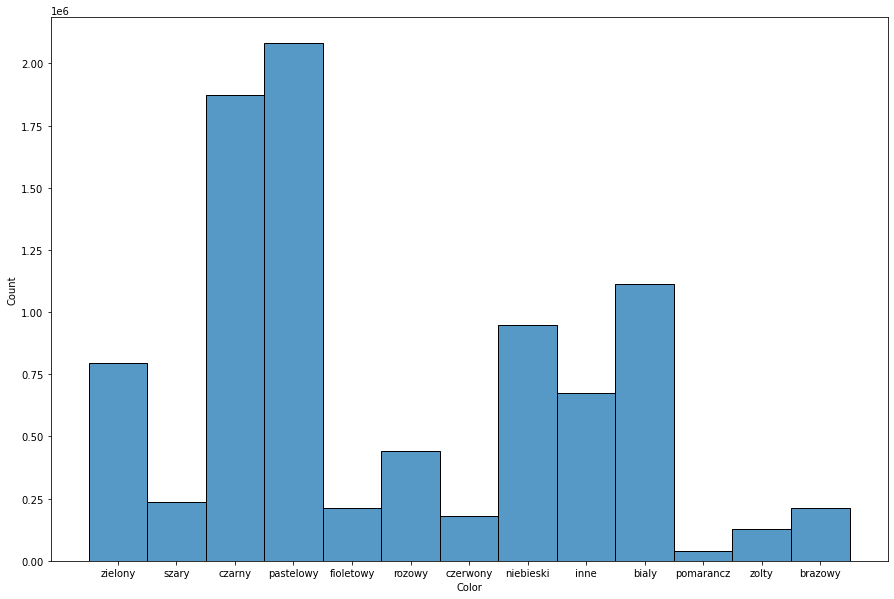

In [266]:
plt.figure(figsize=(15,10))
sns.histplot(bestia['Color'], bins=30);

In [268]:
bestia.to_csv('bestia.csv', index=True)  